### Частина 1. Завантаження, аналіз та підготовка даних

In [1]:
import torch
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from prophet import Prophet
import matplotlib.pyplot as plt
from prophet.plot import plot_plotly
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset, Dataset

In [2]:
df = pd.read_csv('AIR.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-17,0.000000,3.925926,3.814815,3.888889,1.877036,6300
1,1980-03-18,0.000000,3.777778,3.592592,3.703704,1.787653,12100
2,1980-03-19,0.000000,3.666667,3.629630,3.629630,1.751900,6000
3,1980-03-20,0.000000,3.629630,3.481482,3.481482,1.680394,8700
4,1980-03-21,0.000000,3.555556,3.481482,3.518518,1.698272,12300
...,...,...,...,...,...,...,...
10093,2020-03-26,17.260000,20.170000,16.610001,19.950001,19.875002,827300
10094,2020-03-27,19.670000,19.840000,17.680000,17.990000,17.990000,693100
10095,2020-03-30,17.950001,18.260000,16.500000,18.090000,18.090000,489800
10096,2020-03-31,18.120001,18.490000,17.510000,17.760000,17.760000,406600


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10098 entries, 0 to 10097
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       10098 non-null  object 
 1   Open       10098 non-null  float64
 2   High       10098 non-null  float64
 3   Low        10098 non-null  float64
 4   Close      10098 non-null  float64
 5   Adj Close  10098 non-null  float64
 6   Volume     10098 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 552.4+ KB


In [4]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10098.000000,10098.000000,10098.000000,10098.000000,10098.000000,1.009800e+04
mean,16.664906,17.277344,16.779687,17.034560,14.411536,1.767511e+05
std,11.002237,10.608332,10.355031,10.480414,10.825465,2.323537e+05
min,0.000000,1.703704,1.703704,1.703704,0.822321,0.000000e+00
25%,8.916667,9.083333,8.783333,8.916667,5.904892,3.540000e+04
50%,15.250000,15.500000,14.965000,15.230000,11.666778,1.035500e+05
75%,23.820000,24.150000,23.500000,23.807499,21.363298,2.360250e+05
max,52.009998,52.779999,49.070000,51.880001,51.599014,4.345300e+06


### Посуртуємо датафрейми по зростанню часу оскільки ми працюємо із часовими рядами

In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)

In [6]:
df.corr()

,Date,Open,High,Low,Close,Adj Close,Volume
Date,1.000000,0.790042,0.777555,0.772348,0.775107,0.842800,0.468005
Open,0.790042,1.000000,0.995350,0.995015,0.994828,0.976051,0.354012
High,0.777555,0.995350,1.000000,0.999351,0.999600,0.983757,0.357791
Low,0.772348,0.995015,0.999351,1.000000,0.999612,0.982841,0.340837
Close,0.775107,0.994828,0.999600,0.999612,1.000000,0.983661,0.349549
Adj Close,0.842800,0.976051,0.983757,0.982841,0.983661,1.000000,0.374717
Volume,0.468005,0.354012,0.357791,0.340837,0.349549,0.374717,1.000000


#### Бачимо, що Close добре корилює майже зі всіма іншими атрибутами окрім Volume

In [7]:
X = df[['Open', 'High', 'Low', 'Adj Close']]
y = df['Close']
dates = df['Date']
dc = df[['Date', 'Close']]
dc = dc.rename(columns={"Date":"ds","Close":"y"})

#### Окрім розділення даних на y та X із подальшим аналізом їхніх значень, важливо також провірити значення y на автокореляцію з попередніми значеннями, аби можна було виявти чи є взагалі сенс розглядати даний набір даних, якщо значення не залежать одне від одного. Візуалізуємо отримані результати:

<Figure size 1800x1000 with 0 Axes>

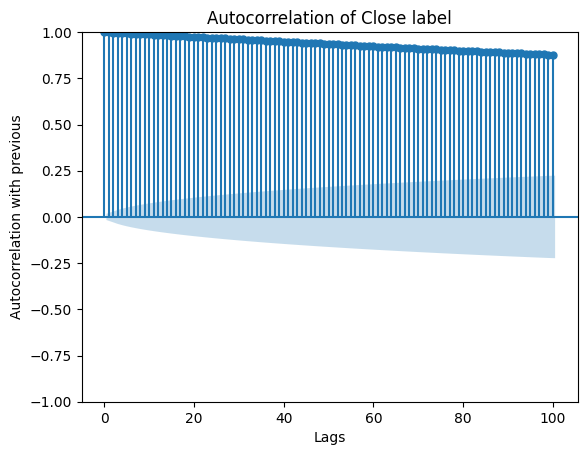

In [8]:
plt.figure(figsize=(18, 10))
plot_acf(y, lags=100, alpha=0.09)
plt.title('Autocorrelation of Close label')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation with previous')
plt.show()

#### Бачимо що по часу є висока кореляція як мінімум для перших 100 значень y, а отже потенційно можливо навчити модель регресії аби прогнозувати дані значення. Для цього для розділення даних застосуємо задану у завданні walk-forward методологію, з кількістю вікон-семплів для навчання рівною 40

In [9]:
def WalkForward(data, target, dates, wsize):
    X, y, date_samples = [], [], []
    for i in range(len(data) - wsize):
        X.append(data[i:i+wsize])
        y.append(target[i+wsize])
        date_samples.append(dates[i+wsize])
    return np.array(X), np.array(y), np.array(date_samples)

def prophet_plotting(dc, test_predictions):
    prophet_model = Prophet()
    prophet_model.fit(dc)
    future = prophet_model.make_future_dataframe(periods=len(test_predictions))
    forecast = prophet_model.predict(future)
    fig = plot_plotly(prophet_model, forecast)
    fig.show()

def plot_results(dates_test, y_test, y_test_pred, dc):
    mse = mean_squared_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)
    print(f'MSE: {mse}, RMSE: {np.sqrt(mse)}, R2: {r2}')
    plt.figure(figsize=(16, 9))
    plt.subplot(1, 2, 2)
    plt.plot(dates_test, y_test, label='Target')
    plt.plot(dates_test, y_test_pred, label='Predicted')
    plt.title('Target VS Predicted')
    plt.xlabel('Year')
    plt.ylabel('Close')
    plt.legend()
    plt.tight_layout()
    plt.show()
    prophet_plotting(dc, y_test_pred)

#### Усі стоврені підмножини даних потрбіних розмірностей, розділимо у співвідношенні 80/20 на тренувальні та тестувальні дані

In [10]:
X = X.values
y = y.values
wsize = 40
X_sample, y_sample, dates_sample = WalkForward(X, y, dates, wsize)
sample_size = int(len(X_sample) * 0.8)

X_train, X_test = X_sample[:sample_size], X_sample[sample_size:]
y_train, y_test = y_sample[:sample_size], y_sample[sample_size:]
dates_train, dates_test = dates_sample[:sample_size], dates_sample[sample_size:]
dc = dc[sample_size:]

# Застосуємо нормалізацію даних, аби моделі швидше навчалися за рахунок того, що всі значення в діапазоні від 0 до 1
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)
y_train_scaled = scaler.fit_transform(y_train.reshape(-1, 1)).reshape(-1)
y_test_scaled = scaler.transform(y_test.reshape(-1, 1)).reshape(-1)

train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(y_train_scaled, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test_scaled, dtype=torch.float32), torch.tensor(y_test_scaled, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
X_train_lr_rf = X_train.reshape(X_train.shape[0], -1)
X_test_lr_rf = X_test.reshape(X_test.shape[0], -1)

### Частина 2 Проектування, та навчання моделей

##LSTM-DNN архітектура

In [11]:
class LSTMDNN(nn.Module):
    def __init__(self, input_size):
        super(LSTMDNN, self).__init__()
        self.lstm = nn.LSTM(input_size, 256, 2, batch_first=True, dropout=0.4)
        self.fc = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        h, c = torch.zeros(2, x.size(0), 256).to(device), torch.zeros(2, x.size(0), 256).to(device)
        out, _ = self.lstm(x, (h, c))
        return self.fc(out[:, -1, :])


## 1D-CNN-LSTM-DNN архітектура

In [12]:
class CNNLSTMDNN(nn.Module):
    def __init__(self, input_size):
        super(CNNLSTMDNN, self).__init__()
        self.cnn = nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=5)
        self.lstm = nn.LSTM(32, 256, 2, batch_first=True, dropout=0.2)
        self.fc = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.cnn(x.permute(0, 2, 1)).permute(0, 2, 1)
        h, c = torch.zeros(2, x.size(0), 256).to(device), torch.zeros(2, x.size(0), 256).to(device)
        out, _ = self.lstm(x, (h, c))
        return self.fc(out[:, -1, :])


### Створимо функцію, в якій будемо навчати і оцінювати результати моделей

In [13]:
def train_test_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    for epoch in range(epochs):
        model.train().to(device)
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets.unsqueeze(1))
            loss.backward()
            optimizer.step()

        model.eval()
        y_pred, y_target = [], []
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                outputs = model(inputs)
                y_pred.append(outputs.cpu().numpy())
                y_target.append(targets.numpy())
        print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

    return np.concatenate(y_pred).ravel(), np.concatenate(y_target).ravel()

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
LR = 0.0001

MSE: 0.0004011694298791289, RMSE: 0.020029214409934527, R2: 0.9939139593228217


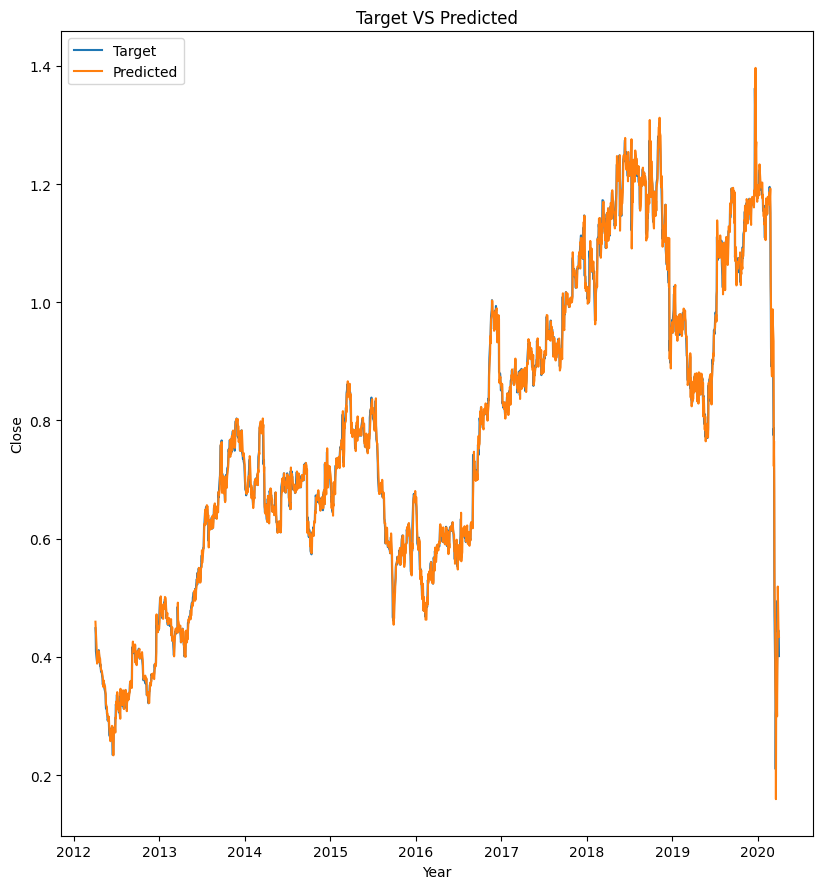

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpti72gped/3qvarx8l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpti72gped/3nizakrw.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=86701', 'data', 'file=/tmp/tmpti72gped/3qvarx8l.json', 'init=/tmp/tmpti72gped/3nizakrw.json', 'output', 'file=/tmp/tmpti72gped/prophet_modelsvghdli2/prophet_model-20240520202709.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:27:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:27:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


MSE: 0.010682763673230117, RMSE: 0.10335745581829169, R2: 0.8379344750183213


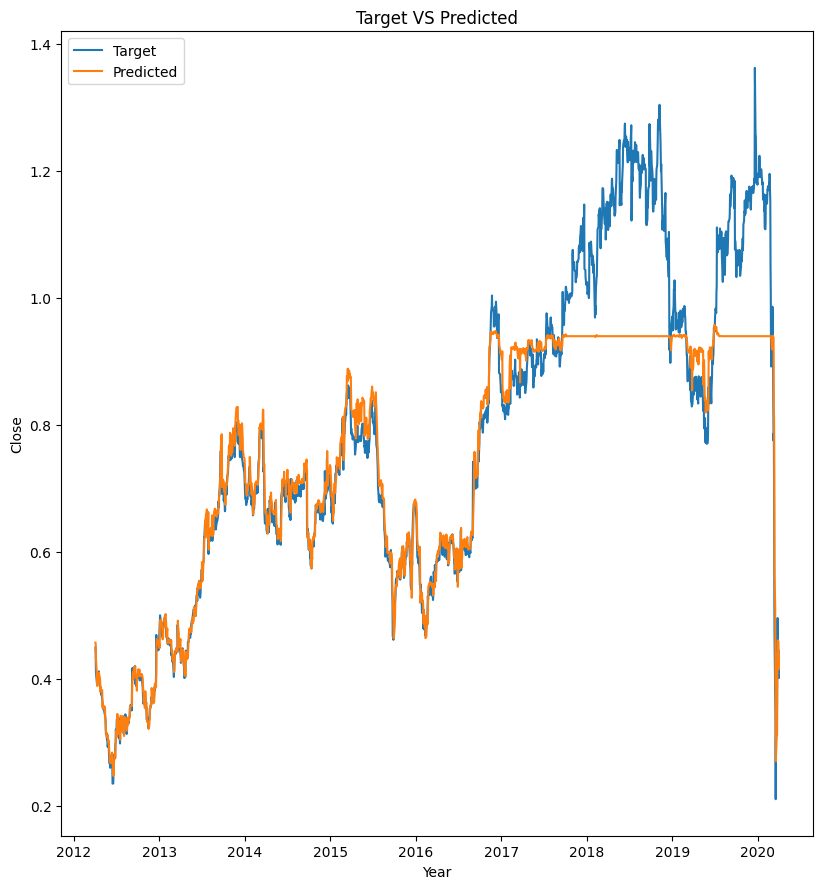

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpti72gped/uny_ch84.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpti72gped/8k442_kx.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=88027', 'data', 'file=/tmp/tmpti72gped/uny_ch84.json', 'init=/tmp/tmpti72gped/8k442_kx.json', 'output', 'file=/tmp/tmpti72gped/prophet_model7mwdlor6/prophet_model-20240520202711.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:27:11 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:27:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Epoch 1/30, Loss: 0.0088
Epoch 2/30, Loss: 0.0062
Epoch 3/30, Loss: 0.0037
Epoch 4/30, Loss: 0.0058
Epoch 5/30, Loss: 0.0046
Epoch 6/30, Loss: 0.0024
Epoch 7/30, Loss: 0.0042
Epoch 8/30, Loss: 0.0045
Epoch 9/30, Loss: 0.0059
Epoch 10/30, Loss: 0.0044
Epoch 11/30, Loss: 0.0069
Epoch 12/30, Loss: 0.0041
Epoch 13/30, Loss: 0.0026
Epoch 14/30, Loss: 0.0047
Epoch 15/30, Loss: 0.0038
Epoch 16/30, Loss: 0.0025
Epoch 17/30, Loss: 0.0026
Epoch 18/30, Loss: 0.0027
Epoch 19/30, Loss: 0.0020
Epoch 20/30, Loss: 0.0030
Epoch 21/30, Loss: 0.0022
Epoch 22/30, Loss: 0.0025
Epoch 23/30, Loss: 0.0031
Epoch 24/30, Loss: 0.0030
Epoch 25/30, Loss: 0.0021
Epoch 26/30, Loss: 0.0026
Epoch 27/30, Loss: 0.0017
Epoch 28/30, Loss: 0.0035
Epoch 29/30, Loss: 0.0020
Epoch 30/30, Loss: 0.0015
MSE: 0.0011851320741698146, RMSE: 0.03442574664950371, R2: 0.9820206596891564


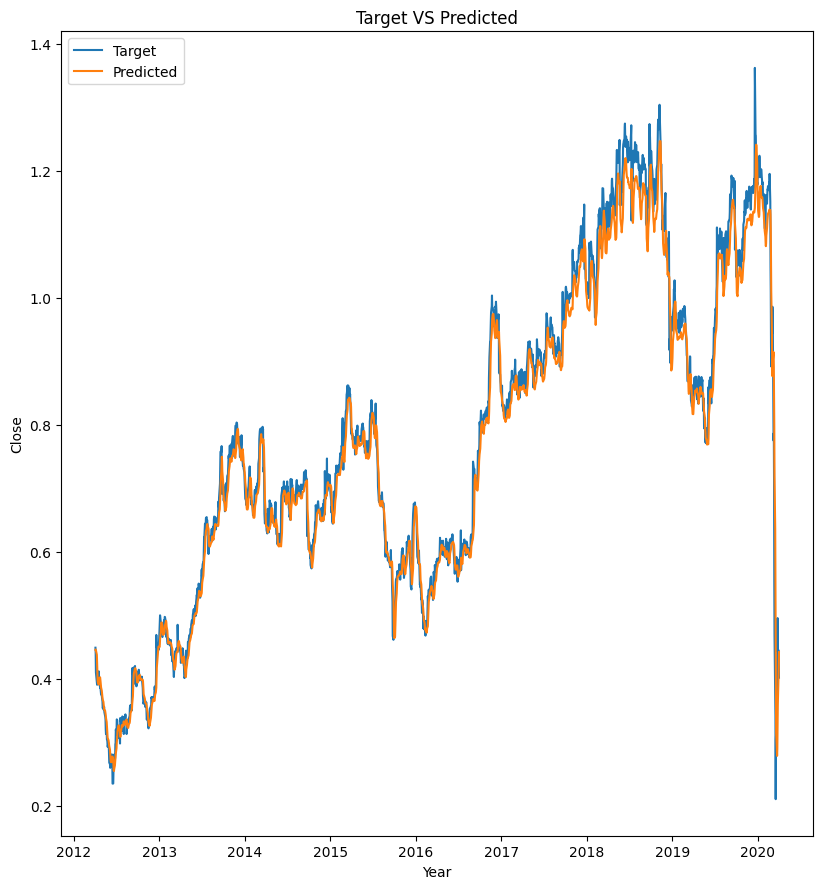

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpti72gped/scalslmc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpti72gped/0n2dlywy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=45911', 'data', 'file=/tmp/tmpti72gped/scalslmc.json', 'init=/tmp/tmpti72gped/0n2dlywy.json', 'output', 'file=/tmp/tmpti72gped/prophet_model59zunhnd/prophet_model-20240520202744.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:27:44 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:27:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Epoch 1/30, Loss: 0.0034
Epoch 2/30, Loss: 0.0027
Epoch 3/30, Loss: 0.0024
Epoch 4/30, Loss: 0.0020
Epoch 5/30, Loss: 0.0027
Epoch 6/30, Loss: 0.0017
Epoch 7/30, Loss: 0.0021
Epoch 8/30, Loss: 0.0018
Epoch 9/30, Loss: 0.0023
Epoch 10/30, Loss: 0.0013
Epoch 11/30, Loss: 0.0013
Epoch 12/30, Loss: 0.0023
Epoch 13/30, Loss: 0.0010
Epoch 14/30, Loss: 0.0009
Epoch 15/30, Loss: 0.0018
Epoch 16/30, Loss: 0.0017
Epoch 17/30, Loss: 0.0014
Epoch 18/30, Loss: 0.0033
Epoch 19/30, Loss: 0.0015
Epoch 20/30, Loss: 0.0011
Epoch 21/30, Loss: 0.0021
Epoch 22/30, Loss: 0.0008
Epoch 23/30, Loss: 0.0005
Epoch 24/30, Loss: 0.0018
Epoch 25/30, Loss: 0.0016
Epoch 26/30, Loss: 0.0011
Epoch 27/30, Loss: 0.0013
Epoch 28/30, Loss: 0.0010
Epoch 29/30, Loss: 0.0011
Epoch 30/30, Loss: 0.0008
MSE: 0.0009448035270906985, RMSE: 0.030737657099962234, R2: 0.9856666230934157


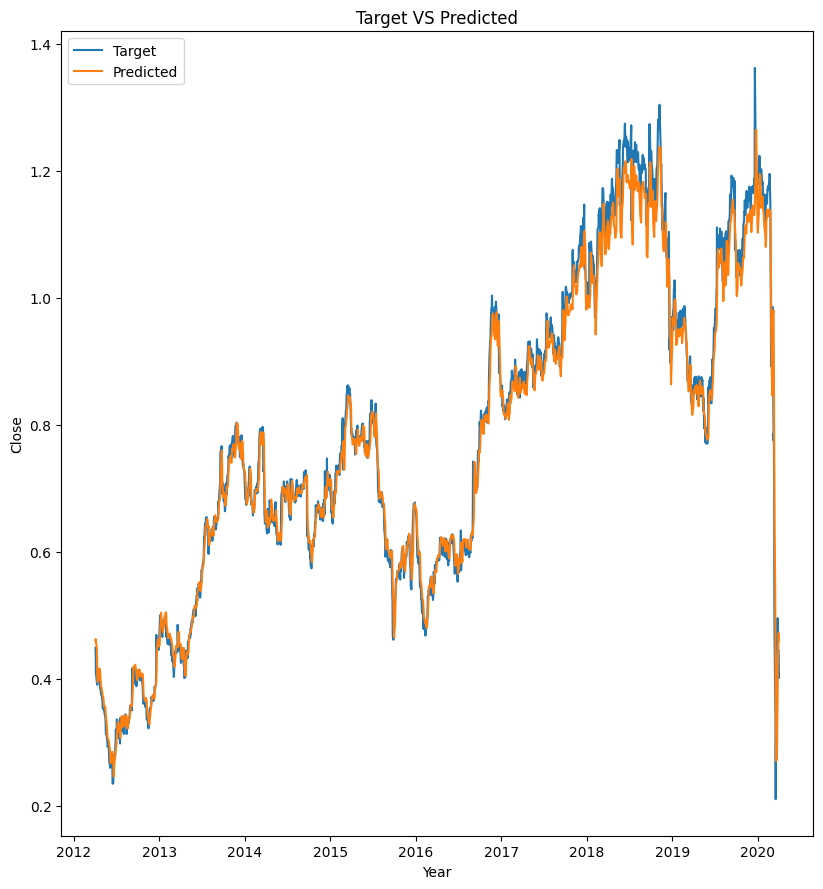

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpti72gped/v6uuoacj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpti72gped/dpk0j0l5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=17906', 'data', 'file=/tmp/tmpti72gped/v6uuoacj.json', 'init=/tmp/tmpti72gped/dpk0j0l5.json', 'output', 'file=/tmp/tmpti72gped/prophet_modelbhwxl_m8/prophet_model-20240520202818.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:28:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:28:18 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [15]:
criterion = nn.MSELoss()

lr_model = LinearRegression()
rf_model = RandomForestRegressor()

lstm_model = LSTMDNN(X_train_scaled.shape[2]).to(device)
optimizer = optim.RMSprop(lstm_model.parameters(), lr=LR)

cnn_model = CNNLSTMDNN(X_train_scaled.shape[2]).to(device)
optimizer2 = optim.RMSprop(cnn_model.parameters(), lr=LR)

lr_model.fit(X_train_lr_rf, y_train_scaled)
rf_model.fit(X_train_lr_rf, y_train_scaled)

y_test_pred_lr = lr_model.predict(X_test_lr_rf)
plot_results(dates_test, y_test_scaled, y_test_pred_lr, dc)

y_test_pred_rf = rf_model.predict(X_test_lr_rf)
plot_results(dates_test, y_test_scaled, y_test_pred_rf, dc)

y_test_pred, y_test_actual = train_test_model(lstm_model, train_loader, test_loader, criterion, optimizer, 30)
plot_results(dates_test, y_test_actual, y_test_pred, dc)

y_test_pred2, y_test_actual2 = train_test_model(cnn_model, train_loader, test_loader, criterion, optimizer2, 30)
plot_results(dates_test, y_test_actual, y_test_pred2, dc)

## Висновок

У процесі реалізації walk-forward методології роздліення даних для датасету AIR.csv з даними NASDAQ, було реалізовано 4 різні моделі регресії для часових рядів, в результаті найкращі значення прогнозування на тестових даних при розбитті у співвідношенні 80/20% тренувальних і тестувальних даних лінійна регресія з точністю 99%, потім модель 1D-CNN-LSTM-DNN із значенням LR=0.0001 та оптимізатором RMSProp імплементації існуючої архітектури із посилання в завданні дала 98,5% точності на тестових даних, в свою чергу LSTM-DNN 98,2%, а найгірші результати на передбачуванні дала модель ансамблевого методу випадкового лісу 83%, що пов'язано з перенавчанням моделі.

<div align="left">
    <h4><b>Виконав:</b></h4>
    <h4>студент</h4>
    <h4>Орлянський Максим</h4>
    <h4><b>Група:</b></h4>
    <h4>КН-317</h4>
    <h4><b>Прийняв:</b></h4>
    <h4>асистент</h4>
    <h4>Гурбич О.В.</h4>
</div>